In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json

constants = json.load(open('constants.json'))
print(constants.keys())

dict_keys(['playable_area', 'pockets'])


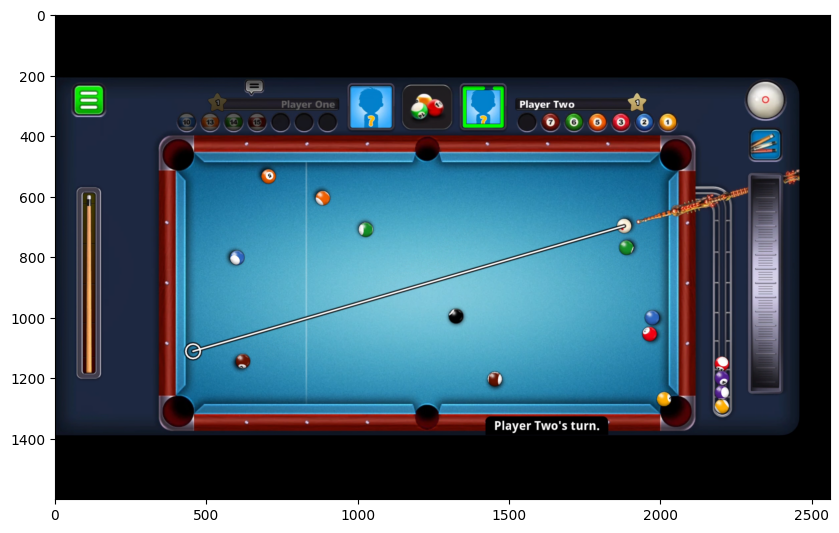

In [44]:
img = cv2.imread('screenshots/screenshot_3.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img)

/tmp/ipykernel_712746/3693499208.py:6: RuntimeWarning: invalid value encountered in divide
  normalized_image = image / sum_channels


Text(0.5, 1.0, 'Normalized Image')

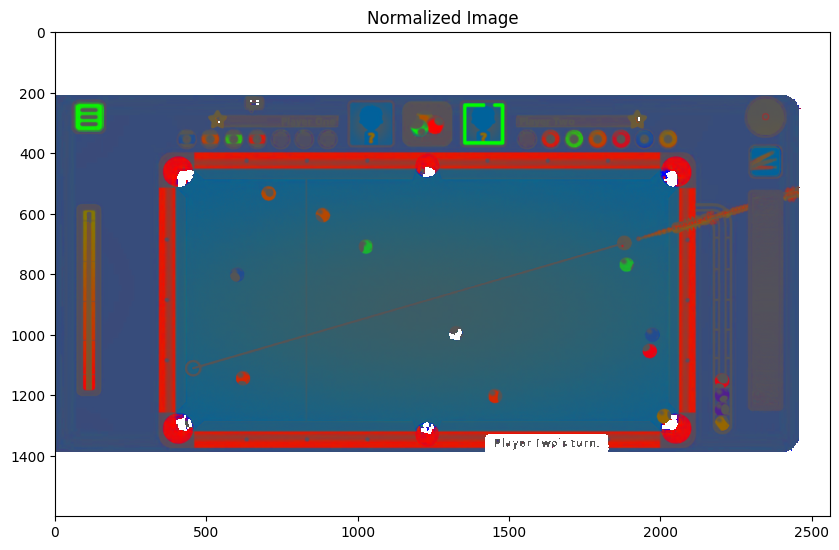

In [45]:
# normalize image: r = (R / (R + G + B)), g = (G / (R + G + B)), b = (B / (R + G + B)), r + g + b = 1
# following paper
def normalize_image(image):
    image = image.astype(np.float32) / 255.0
    sum_channels = np.sum(image, axis=2, keepdims=True)
    normalized_image = image / sum_channels

    return normalized_image

norm_img = normalize_image(img)
plt.figure(figsize=(10, 10))
plt.imshow(norm_img)
plt.title('Normalized Image')


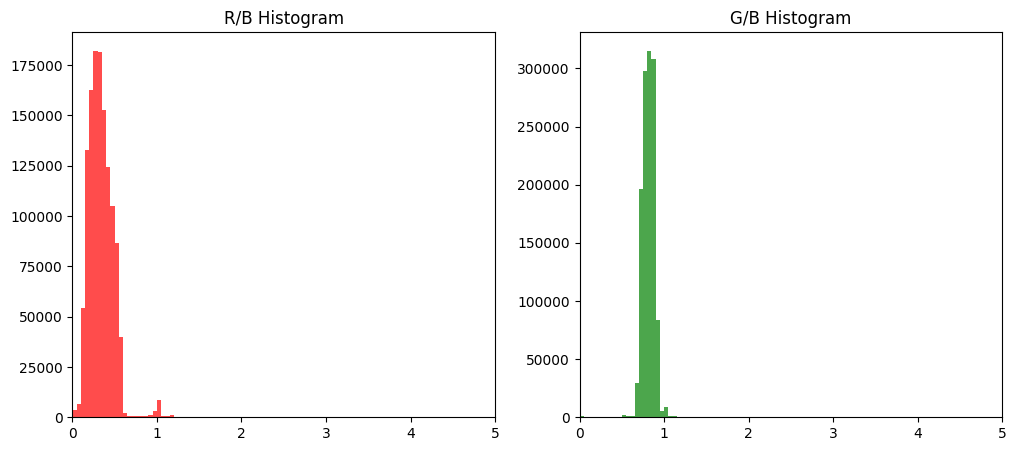

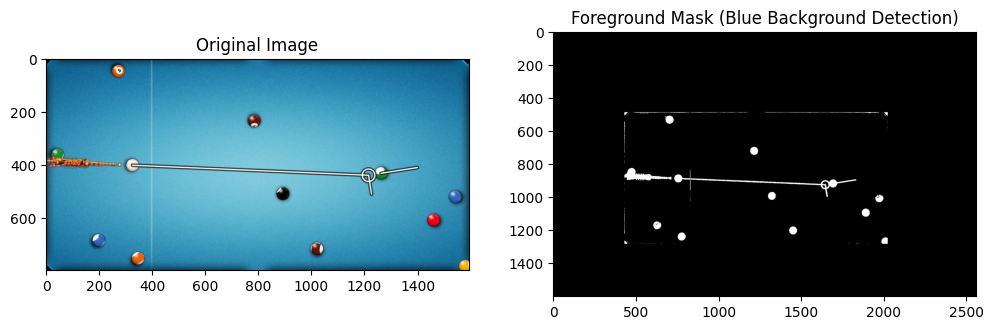

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from PIL import Image

# --- Step 1: Normalize ---
def normalize_image(image):
    image = image.astype(np.float32) / 255.0
    sum_channels = np.sum(image, axis=2, keepdims=True)
    sum_channels[sum_channels == 0] = 1.0
    return image / sum_channels

# --- Step 2: Compute R/B and G/B ratios ---
def compute_rb_gb_ratios(norm_img):
    R = norm_img[..., 0]
    G = norm_img[..., 1]
    B = norm_img[..., 2]
    B[B == 0] = 1e-6  # avoid division by zero
    return R / B, G / B

# --- Step 3: Gaussian thresholding ---
def compute_gaussian_thresholds(ratio, k):  # 95% confidence
    flat = ratio.flatten()
    flat = flat[np.isfinite(flat) & (flat < 3)]  # filter extreme outliers
    mu, std = norm.fit(flat)
    return mu - k * std, mu + k * std

# --- Step 4: Foreground mask ---
def create_foreground_mask(rb_ratio, gb_ratio, rb_thresh, gb_thresh):
    rb_mask = (rb_ratio >= rb_thresh[0]) & (rb_ratio <= rb_thresh[1])
    gb_mask = (gb_ratio >= gb_thresh[0]) & (gb_ratio <= gb_thresh[1])
    background_mask = rb_mask & gb_mask
    return ~background_mask  # invert to get foreground

y1, x1 = 490, 432
y2, x2 = 1285, 2026

# --- Load image from PIL ---
img_pil = Image.open('screenshots/screenshot_2.png')
img = np.array(img_pil)
h, w = img.shape[:2]

# Crop to just the table region
cropped_img = img[y1:y2, x1:x2]

# Normalize and compute ratios
norm_img = normalize_image(cropped_img)
rb_ratio, gb_ratio = compute_rb_gb_ratios(norm_img)

# Plot histograms
rb_flat = rb_ratio.flatten()
gb_flat = gb_ratio.flatten()
rb_filtered = rb_flat[np.isfinite(rb_flat) & (rb_flat < 5)]
gb_filtered = gb_flat[np.isfinite(gb_flat) & (gb_flat < 5)]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(rb_filtered, bins=100, color='red', alpha=0.7)
plt.title("R/B Histogram")
plt.xlim(0, 5)

plt.subplot(1, 2, 2)
plt.hist(gb_filtered, bins=100, color='green', alpha=0.7)
plt.title("G/B Histogram")
plt.xlim(0, 5)
plt.show()

# Thresholds
rb_thresh = compute_gaussian_thresholds(rb_ratio, k=1.5)
gb_thresh = compute_gaussian_thresholds(gb_ratio, k=1.5)

# Create and embed full-size mask
foreground_mask = create_foreground_mask(rb_ratio, gb_ratio, rb_thresh, gb_thresh)
full_mask = np.zeros((h, w), dtype=np.uint8)
full_mask[y1:y2, x1:x2] = foreground_mask.astype(np.uint8) * 255

# Visualize result
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(cropped_img)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(full_mask, cmap='gray')
plt.title("Foreground Mask (Blue Background Detection)")
plt.show()


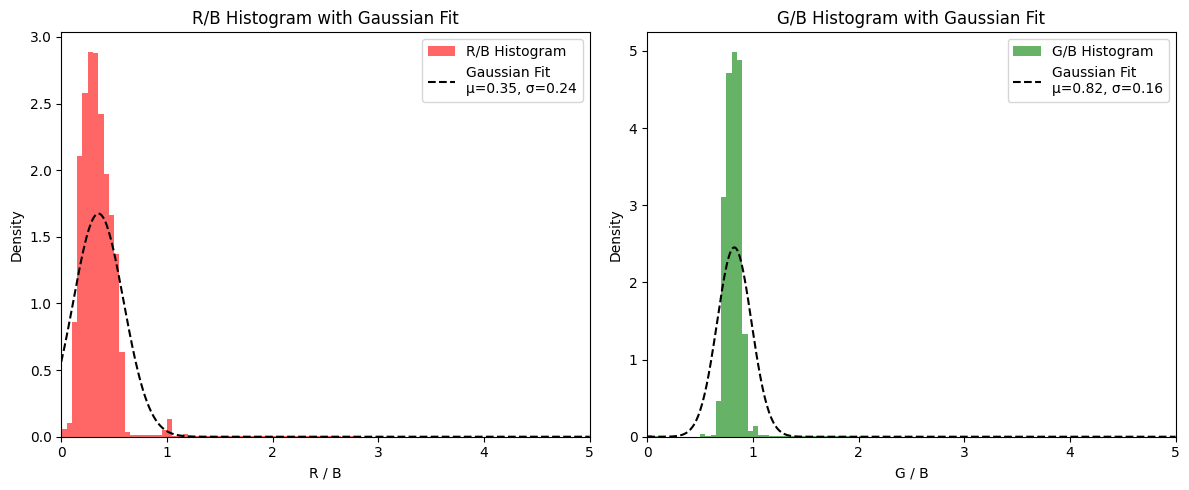

In [47]:
# Fit Gaussians
rb_mu, rb_std = norm.fit(rb_filtered)
gb_mu, gb_std = norm.fit(gb_filtered)

# Generate x-values for PDF curve
x_rb = np.linspace(0, 5, 500)
x_gb = np.linspace(0, 5, 500)

# Compute the PDF using the fitted parameters
rb_pdf = norm.pdf(x_rb, rb_mu, rb_std)
gb_pdf = norm.pdf(x_gb, gb_mu, gb_std)

# Plot histograms with fitted Gaussian
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(rb_filtered, bins=100, color='red', alpha=0.6, density=True, label='R/B Histogram')
plt.plot(x_rb, rb_pdf, 'k--', label=f'Gaussian Fit\nμ={rb_mu:.2f}, σ={rb_std:.2f}')
plt.title("R/B Histogram with Gaussian Fit")
plt.xlabel("R / B")
plt.ylabel("Density")
plt.legend()
plt.xlim(0, 5)

plt.subplot(1, 2, 2)
plt.hist(gb_filtered, bins=100, color='green', alpha=0.6, density=True, label='G/B Histogram')
plt.plot(x_gb, gb_pdf, 'k--', label=f'Gaussian Fit\nμ={gb_mu:.2f}, σ={gb_std:.2f}')
plt.title("G/B Histogram with Gaussian Fit")
plt.xlabel("G / B")
plt.ylabel("Density")
plt.legend()
plt.xlim(0, 5)

plt.tight_layout()
plt.show()

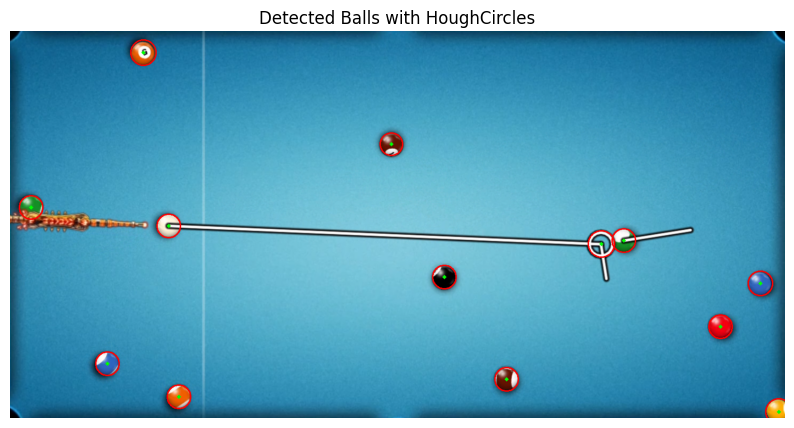

In [48]:
import cv2

# Convert mask to proper format for OpenCV
mask_for_cv = foreground_mask.astype(np.uint8) * 255

# Apply Gaussian blur (helps Hough detection)
blurred = cv2.GaussianBlur(mask_for_cv, (9, 9), 2)

# Hough Circle detection
circles = cv2.HoughCircles(
    blurred,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=30,       # minimum distance between circles
    param1=80,        # higher threshold for edge detection (Canny)
    param2=20,        # accumulator threshold (lower = more sensitive)
    minRadius=22,
    maxRadius=28
)

# Draw the circles on a copy of the cropped image
output_img = cropped_img.copy()

if circles is not None:
    circles = np.uint16(np.around(circles))
    for (x, y, r) in circles[0, :]:
        cv2.circle(output_img, (x, y), r, (255, 0, 0), 2)  # blue circle
        cv2.circle(output_img, (x, y), 2, (0, 255, 0), 3)  # green center
else:
    print("No circles detected.")

# Show result
plt.figure(figsize=(10, 10))
plt.imshow(output_img)
plt.title("Detected Balls with HoughCircles")
plt.axis('off')
plt.show()
